# Crosstalk Subtraction Signal Loss Test

**Josh Dillon 5/16/22**

This notebook performs the final power spectrum analysis for the Validation test of signal loss due to crosstalk subtraction. It compares power spectra that:

* just use an EoR model, no foregrounds
* are simulated on LST grid matching that of all epochs binned together
* without any flags or systematics

with power spectra that:

* are simulated one per epoch on each epoch's LST-binned grid
* are simulated with EoR and foregrounds
* have crosstalk added, which differs from epoch to epoch, but no noise or calibration errors
* are flagged, inpainted, and crosstalk subtracted on a per-epoch basis
* have all four epochs LST-binned together.

In [1]:
import hera_pspec as hp
import numpy as np
from utils import load_red_uvps, red_avg
import matplotlib.pyplot as plt
import copy
import scipy
import matplotlib
%matplotlib notebook

In [2]:
# file containing final per-baseline power spectra 
df = '/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/fg_only/all_epochs_preprocessed/pspec/pspec.grp1.of1.LPXLTK.h5'

# load pspec container for cross-talk subtracted files
psc = hp.container.PSpecContainer(df, keep_open=False)
uvps_xtk, lens, angs, Nblps = load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

# Redundant average
uvp_xtk_ravg = red_avg(uvps_xtk, exclude_autos=False, exclude_cross=True, error_weights='P_N')

In [3]:
# Load true eor with the same level of time averaging
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/eor_only/all_epochs/pspec/pspec.grp1.of1.true_eor.TK.h5", keep_open=False)
uvps_eor_TK, lens, angs, Nblps  = load_red_uvps(psc, 'stokespol')

In [4]:
# set all noise power spectra to unity
for uvps in uvps_eor_TK:
    for key in uvps.get_all_keys():
        uvps.set_stats('P_N', key, np.ones_like(uvps.get_data(key), dtype=float))

In [5]:
# Load true sum (with systematics but no noise) with cross-talk subtraction performed
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/true_sum/all_epochs_preprocessed/pspec/pspec.grp1.of1.PXLTK.h5", keep_open=False)
uvps_PXLTK, lens, angs, Nblps = load_red_uvps(psc, 'stokespol')

In [6]:
def find_index_of_key(key, list_of_uvps):
    '''This function figures out which UVPspec object in a list has a given key. 
    Returns None if not any of them.'''
    for i, uvp in enumerate(list_of_uvps):
        if key in uvp.get_all_keys():
            return i
    return None    

In [7]:
# copy weights from end-to-end simulation to true sum simulation
for uvp_PXLTK in uvps_PXLTK:
    keys_here = uvp_PXLTK.get_all_keys()
    corresponding_uvp = uvps_xtk[find_index_of_key(keys_here[0], uvps_xtk)]
    assert keys_here == corresponding_uvp.get_all_keys()
    
    uvp_PXLTK.stats_array = corresponding_uvp.stats_array

    for key in keys_here:
        np.testing.assert_array_equal(uvp_PXLTK.get_stats('P_N', key), corresponding_uvp.get_stats('P_N', key))
            

In [8]:
# Redundantly average
uvp_PXLTK_ravg = red_avg(uvps_PXLTK, exclude_autos=False, exclude_cross=True, error_weights='P_N')
uvp_eor_TK_ravg = red_avg(uvps_eor_TK, exclude_autos=False, exclude_cross=True, error_weights='P_N')

In [9]:
# copy weights from redundantly-averaged end-to-end simulation to EoR only simulation
xtk_blps = uvp_xtk_ravg.get_blpairs()
xtk_vecs = uvp_xtk_ravg.bl_vecs
key_map = {}
for blp, vec in zip(uvp_eor_TK_ravg.get_blpairs(), uvp_eor_TK_ravg.bl_vecs):
    assert np.min(np.linalg.norm(xtk_vecs[:, :2] - vec[:2], axis=1)) < 1
    closest_blp = xtk_blps[np.argmin(np.linalg.norm(xtk_vecs[:, :2] - vec[:2], axis=1))]
    for i in uvp_eor_TK_ravg.spw_array:
        key_map[(i, blp, ('pI', 'pI'))] = (i, closest_blp, ('pI', 'pI'))
        
for key in uvp_eor_TK_ravg.get_all_keys():
    uvp_eor_TK_ravg.set_stats('P_N', key, uvp_xtk_ravg.get_stats('P_N', key_map[key]))        

In [10]:
# Spherical Binning Cuts
wedge_buff_ns = 300
sph_minimum_ew_distance = 15
sph_minimum_bl_length = 0
sph_maximum_bl_length = 1e100

# Spherical Binning Parameters
dk_multiplier = 2.0 # the size of each spherical k bin (Delta k) when multiplied by the natural k_para spacing
k_start_multiplied = .75 # the center of first spherical k bin in units of Delta k

In [11]:
# perform spherical binning, cutting out the wedge and baselines that we ultimately want to remove
eor_band_1 = uvp_eor_TK_ravg.select(spws=[0], inplace=False)
eor_band_2 = uvp_eor_TK_ravg.select(spws=[1], inplace=False)
true_sum_band_1 = uvp_PXLTK_ravg.select(spws=[0], inplace=False)
true_sum_band_2 = uvp_PXLTK_ravg.select(spws=[1], inplace=False)

def spherical_average(uvp):   
    dk = dk_multiplier * np.median(np.diff(uvp.get_kparas(0)))
    kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 
    
    uvp.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)

    # cut baselines by setting noise to infinity
    for blp, blvec in zip(uvp.get_blpairs(), uvp.get_blpair_blvecs()):
        cut = False
        if np.linalg.norm(blvec) < sph_minimum_bl_length:
            cut = True
        if np.linalg.norm(blvec) > sph_maximum_bl_length:
            cut = True
        if np.abs(blvec[0]) < sph_minimum_ew_distance:
            cut = True
        if cut:
            for spw in uvp.spw_array:
                for pp in uvp.get_polpairs():
                    k = (spw, blp, pp)
                    uvp.set_stats('P_N', k, np.ones_like(uvp.get_stats('P_N', k)) * np.inf)

    # spherical average
    return hp.grouping.spherical_average(uvp, kbins, dk, error_weights='P_N')


eor_band_1 = spherical_average(eor_band_1)
eor_band_2 = spherical_average(eor_band_2)
true_sum_band_1 = spherical_average(true_sum_band_1)
true_sum_band_2 = spherical_average(true_sum_band_2)

/users/jsdillon/lustre/tmp/ipykernel_7366/3865595508.py:25: RuntimeWarning: invalid value encountered in multiply
  uvp.set_stats('P_N', k, np.ones_like(uvp.get_stats('P_N', k)) * np.inf)


In [84]:
# save results for external plotting without all the I/O
eor_band_1.write_hdf5('P_of_kt_eor_band_1.h5', overwrite=True)
eor_band_2.write_hdf5('P_of_kt_eor_band_2.h5', overwrite=True)
true_sum_band_1.write_hdf5('P_of_kt_true_sum_band_1.h5', overwrite=True)
true_sum_band_2.write_hdf5('P_of_kt_true_sum_band_2.h5', overwrite=True)

lst_indexes = np.unique(uvp_eor_TK_ravg.lst_1_array, return_index=True)[1]
lsts = np.unwrap([uvp_eor_TK_ravg.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi - 24
np.savez('xtalk_test_lsts.npz', lsts=lsts)

In [81]:
# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]
lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

<IPython.core.display.Javascript object>


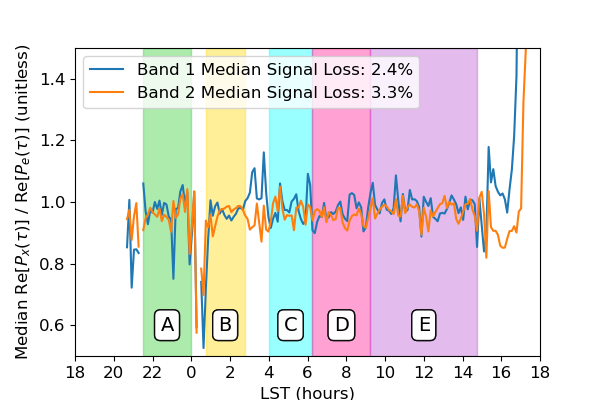

/users/jsdillon/lustre/tmp/ipykernel_7366/3075130102.py:6: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))


In [82]:
# plot results
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100, sharex=True, gridspec_kw={'hspace': 0})

for band, true_sum, eor, color in zip([1, 2], [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2], ['C0', 'C1']):
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))

    subset = ratio[:, (eor.dly_array * 1e9 < 4000)]
    
    use_this_lst = np.zeros_like(lsts, dtype=bool)
    for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
        use_this_lst[(lsts > lc[0]) & (lsts < lc[1])] = True
        ax.text(np.mean(lc), .6, f'{"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))

    
    
    ax.plot(lsts, np.nanmedian(subset, axis=1), c=color, 
            label=f'Band {band} Median Signal Loss: {1 - np.nanmedian(subset[use_this_lst]):.1%}')
    
for lc, c in zip(lstcuts, lst_colors):
    ax.axvspan(lc[0], lc[1], color=c, alpha=.4)    
ax.set_ylim([.5, 1.5])
ax.set_xticks(np.arange(-6, 20, 2), fontsize=12)
ax.set_xlim([-6,18])
ax.set_xticklabels(np.arange(-6, 20, 2) % 24, fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.xlabel('LST (hours)', size=12)
plt.ylabel('Median Re$[P_{x}(\\tau)]$ / Re$[P_{e}(\\tau)]$ (unitless)', size=12)
plt.legend(fontsize=12)

<IPython.core.display.Javascript object>


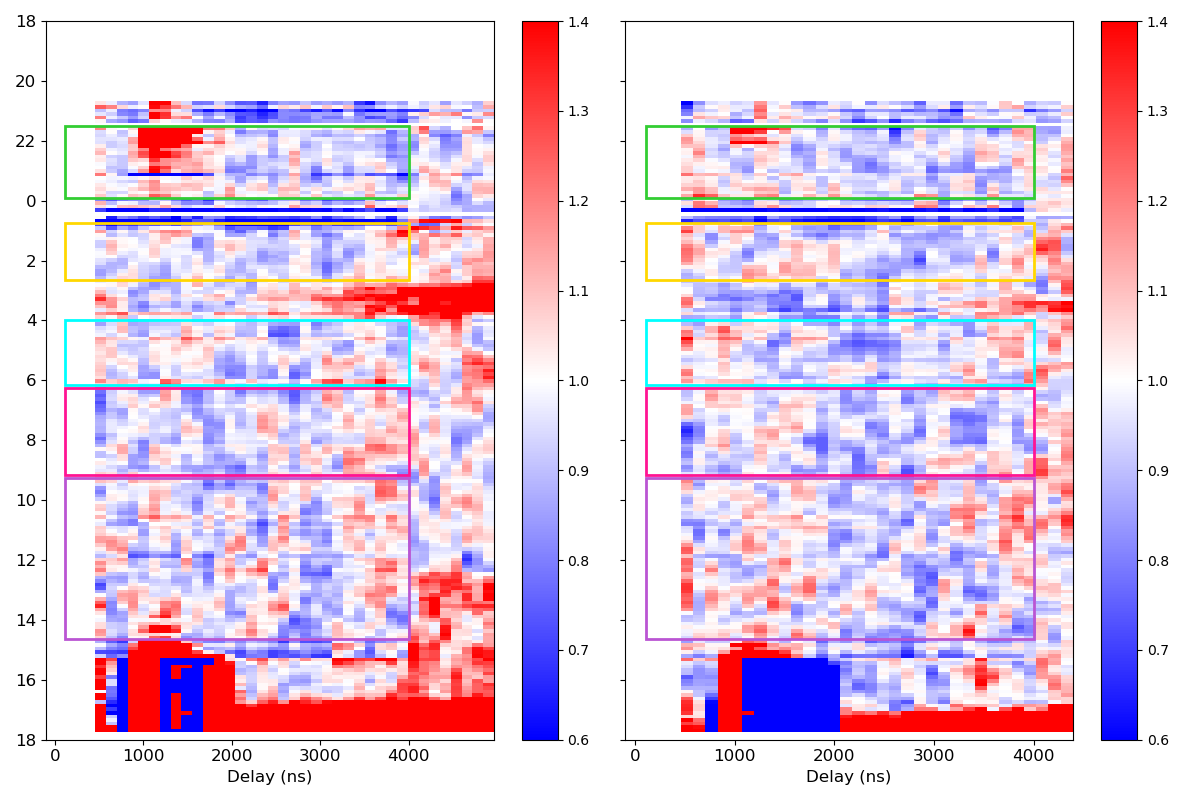

/users/jsdillon/lustre/tmp/ipykernel_7366/3677438910.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))


In [83]:
# unfinished backup version of plot
lst_indexes = np.unique(uvp_eor_TK_ravg.lst_1_array, return_index=True)[1]
lsts = np.unwrap([uvp_eor_TK_ravg.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi - 24

fix, axes = plt.subplots(1, 2,figsize=(12,8), dpi=100, sharey=True)
for ax, true_sum, eor in zip(axes, [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2]):

    extent = [eor.dly_array[0] * 1e9, eor.dly_array[-1] * 1e9, lsts[-1], lsts[0]]
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))
    im = ax.imshow(ratio, aspect='auto', interpolation='none', cmap='bwr', extent=extent, vmin=.6, vmax=1.4)
    plt.colorbar(im, ax=ax)
    for i, lc in enumerate(lstcuts):
        r = plt.Rectangle((110, lc[0]), 3890, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
        ax.add_patch(r)
        
        subset = ratio[(lsts > lc[0]) & (lsts < lc[1])]
        subset = subset[:, (eor.dly_array * 1e9 < 4000)]
#         print('Field ' + 'ABCDE'[i] + ':', np.nanmean(subset))
        ax.set_xlim(-100)
        ax.set_yticks(np.arange(-6, 20, 2))
        axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('Delay (ns)', fontsize=12)        

plt.tight_layout()